In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

In [60]:
def savearray(q, n, arr, filename):
    f = open(filename, 'w')
    for idx in product(range(n), repeat=q):
            f.write(str(np.array(idx)) + ' ')
            for elem in arr[idx]:
                f.write(str(elem) + ' ')
            f.write('\n')
    f.close() 
    
def saveall(JP_pred, JE_pred, UP_pred, UE_pred):
    savearray(3, 11, JP_pred, 'without_tt_jp.txt')
    savearray(3, 11, JE_pred, 'without_tt_je.txt')
    savearray(4, 11, UP_pred, 'without_tt_up.txt')
    savearray(4, 11, UE_pred, 'without_tt_ue.txt')    

In [61]:
Delta_max = 1e-2 
delta_max = 1e-2 
gamma = 0.7
K_max = 50
k_max = 100

from_ = 0
to_ = 10
n = 11

In [62]:
def get_data(from_, to_, n):
    x_grid = np.linspace(from_, to_, n)
    y_grid = np.linspace(from_, to_, n)
    
    return x_grid, y_grid

In [63]:
JP_pred = np.zeros((n, n, n, n))
JE_pred = np.zeros((n, n, n, n))
JP_next = np.zeros((n, n, n, n))
JE_next = np.zeros((n, n, n, n))
JP = np.zeros((n, n, n, n))
JE = np.zeros((n, n, n, n))
G = np.zeros((n, n, n, n))
sizes = np.array([n, n, n, n]).astype(int)
UP_pred = np.zeros((n, n, n, n, 2)).astype(int)
UE_pred = np.zeros((n, n, n, n, 2)).astype(int)
UP_next = np.zeros((n, n, n, n, 2)).astype(int)
UE_next = np.zeros((n, n, n, n, 2)).astype(int)
x_grid, y_grid = get_data(from_, to_, n)
up_x = np.arange(-2, 3).astype(int)
up_y = np.arange(-2, 3).astype(int)
ue_x = np.arange(-1, 2).astype(int)
ue_y = np.arange(-1, 2).astype(int)

In [64]:
for idx, val in zip(product(range(n), repeat=4), product(x_grid, y_grid, x_grid, y_grid)):
    JP_pred[idx] = (val[0] - val[2]) ** 2 + (val[1] - val[3]) ** 2 
    JE_pred[idx] = (val[0] - val[2]) ** 2 + (val[1] - val[3]) ** 2
    G[idx] = (val[0] - val[2]) ** 2 + (val[1] - val[3]) ** 2 + 10

In [65]:
def get_neighbors(idx, sizes, up, ue, mode):
    up = up.astype(int)
    ue = ue.astype(int)
    neighbors = list()
    pos_list = list()
    if mode == 'p':
        z = list(idx)
        z[2] += ue[0]
        z[3] += ue[1]
        for positions in product(up_x, up_y):
            if ((idx[0] + positions[0] >= 0) and (idx[0] + positions[0] < sizes[0]) and 
                (idx[1] + positions[1] >= 0) and (idx[1] + positions[1] < sizes[1])):
                z[0] = idx[0] + positions[0]
                z[1] = idx[1] + positions[1]
                neighbors.append(tuple(z))
                pos_list.append(np.array(positions))
    if mode == 'e':
        z = list(idx)
        z[0] += up[0]
        z[1] += up[1]
        for positions in product(ue_x, ue_y):
            if ((idx[2] + positions[0] >= 0) and (idx[2] + positions[0] < sizes[2]) and 
                (idx[3] + positions[1] >= 0) and (idx[3] + positions[1] < sizes[3])):
                z[2] = idx[2] + positions[0]
                z[3] = idx[3] + positions[1]
                neighbors.append(tuple(z))
                pos_list.append(np.array(positions))
                
    return neighbors, pos_list

In [66]:
def solve(neighbors, pos_list, G, J_pred, mode, gamma=0.7):
    function_vals = np.zeros(len(neighbors))
    for i, neighbor in enumerate(neighbors):
        function_vals[i] = G[neighbor] + gamma * J_pred[neighbor]
    if mode == 'p':
        idx = np.argmin(function_vals)
        val = function_vals[idx]
        pos = pos_list[idx]
    elif mode == 'e':
        idx = np.argmax(function_vals)
        val = function_vals[idx]
        pos = pos_list[idx]
    else:
        print 'Mode is not correct!'
    
    return val, pos

In [67]:
f_r = open('without_tt_report.txt', 'w')
JP = JP_pred.copy()
JE = JE_pred.copy()
Delta_p = Delta_max + 1
Delta_e = Delta_max + 1
K = 0
while ((Delta_p > Delta_max) and (Delta_e > Delta_max) and (K < K_max)):
    delta = delta_max + 1
    k = 0
    while ((delta > delta_max) and (k < k_max)):
        for idx in product(range(n), repeat=4):
            neighbors, pos_list = get_neighbors(idx, sizes, up=np.zeros(2), ue=UE_pred[idx], mode='p')
            JP_next[idx], UP_next[idx] = solve(neighbors, pos_list, G, JP_pred, mode='p')
        k += 1
        delta = np.linalg.norm(JP_next - JP_pred) ** 2
        JP_pred = JP_next.copy()
        UP_pred = UP_next.copy()
        f_r.write('P ' + str(k) + ' ' + str(delta) + '\n')
    delta = delta_max + 1
    k = 0
    while ((delta > delta_max) and (k < k_max)):
        for idx in product(range(n), repeat=4):
            neighbors, pos_list = get_neighbors(idx, sizes, up=UP_pred[idx], ue=np.zeros(2), mode='e')
            JE_next[idx], UE_next[idx] = solve(neighbors, pos_list, G, JE_pred, mode='e')
        k += 1
        delta = np.linalg.norm(JE_next - JE_pred) ** 2
        JE_pred = JE_next.copy()
        UE_pred = UE_next.copy()
        f_r.write('E ' + str(k) + ' ' + str(delta) + '\n')
    Delta_p = np.linalg.norm(JP - JP_pred) ** 2
    Delta_e = np.linalg.norm(JE - JE_pred) ** 2
    JE = JE_pred.copy()
    JP = JP_pred.copy()
    UE = UE_pred.copy()
    UP = UP_pred.copy()
    K += 1
    f_r.write('K ' + str(K) + ' ' + str(Delta_p) + ' ' + str(Delta_e) + '\n')  
f_r.close()

In [68]:
saveall(JP_pred, JE_pred, UP_pred, UE_pred)

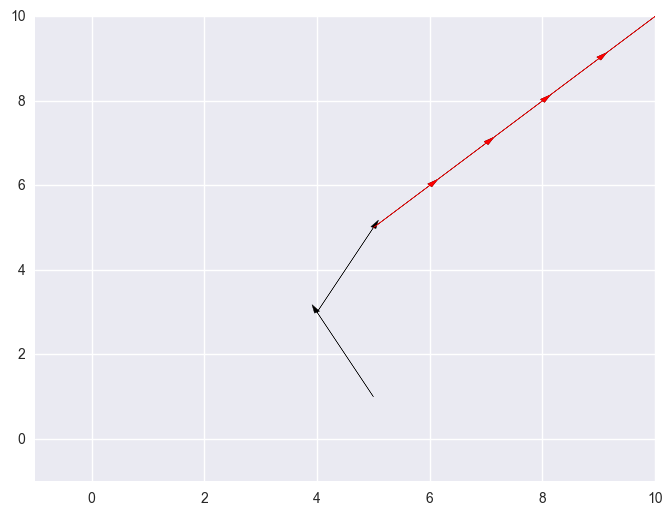

In [327]:
z_init = (5, 1, 5, 5)
p_pos_array = []
e_pos_array = []
p_pos = np.array(z_init[:2])
e_pos = np.array(z_init[2:])
for i in range(10):
    p_pos_array.append(p_pos)
    e_pos_array.append(e_pos)
    p_pos = np.array(p_pos) + UP[p_pos[0], p_pos[1], e_pos[0], e_pos[1]]
    e_pos = np.array(e_pos) + UE[p_pos[0], p_pos[1], e_pos[0], e_pos[1]]
    
plt.figure(figsize=(8, 6))
#for i in range(10):
#    plt.plot(p_pos_array[i][0], p_pos_array[i][1], 'ro', markersize=10)
    
for i in range(9):
    x_start = p_pos_array[i][0]
    y_start = p_pos_array[i][1]
    dx = p_pos_array[i + 1][0] - p_pos_array[i][0]
    dy = p_pos_array[i + 1][1] - p_pos_array[i][1]
    plt.arrow(x_start, y_start, dx, dy, head_width=0.1, head_length=0.2, fc='k', ec='k')
    
#for i in range(10):
#    plt.plot(e_pos_array[i][0], e_pos_array[i][1], 'bo')

for i in range(9):
    x_start = e_pos_array[i][0]
    y_start = e_pos_array[i][1]
    dx = e_pos_array[i + 1][0] - e_pos_array[i][0]
    dy = e_pos_array[i + 1][1] - e_pos_array[i][1]
    plt.arrow(x_start, y_start, dx, dy, head_width=0.1, head_length=0.2, fc='r', ec='r')
    
plt.xlim((-1, 10))
plt.ylim((-1, 10))
plt.show()

In [328]:
p_pos_array

[array([5, 1]),
 array([4, 3]),
 array([5, 5]),
 array([6, 6]),
 array([7, 7]),
 array([8, 8]),
 array([9, 9]),
 array([10, 10]),
 array([11, 11]),
 array([12, 12])]

In [329]:
e_pos_array

[array([5, 5]),
 array([6, 6]),
 array([7, 7]),
 array([8, 8]),
 array([9, 9]),
 array([10, 10]),
 array([11, 11]),
 array([12, 12]),
 array([13, 13]),
 array([14, 14])]

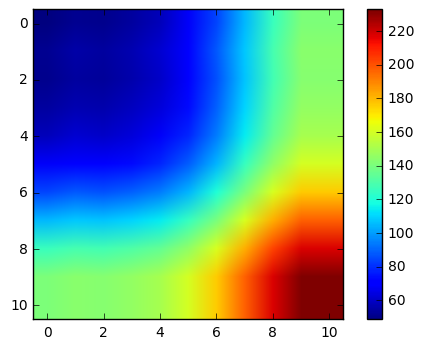

In [35]:
plt.imshow(JE[0, 0, :, :])
plt.colorbar()
plt.show()